In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import torch
import itertools
from torchsummary import summary


# **Dataset Acquisition and Preprocessing**

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])


image, label = dataset[0]

print('image size = ',image.size)

print(f'Dataset size: {len(dataset)}')

Files already downloaded and verified
Files already downloaded and verified
image size =  <built-in method size of Tensor object at 0x7fd1247fe270>
Dataset size: 60000


/Users/zeinebtekaya/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for i in range(10):
    image, label = dataset[i]
    print(f'Label: {label} - Class: {classes[label]} - Image size: {image.size}')

Label: 6 - Class: frog - Image size: <built-in method size of Tensor object at 0x7fd124804ae0>
Label: 9 - Class: truck - Image size: <built-in method size of Tensor object at 0x7fd10068af40>
Label: 9 - Class: truck - Image size: <built-in method size of Tensor object at 0x7fd124804040>
Label: 4 - Class: deer - Image size: <built-in method size of Tensor object at 0x7fd124804ae0>
Label: 1 - Class: car - Image size: <built-in method size of Tensor object at 0x7fd10068af40>
Label: 1 - Class: car - Image size: <built-in method size of Tensor object at 0x7fd11097d130>
Label: 2 - Class: bird - Image size: <built-in method size of Tensor object at 0x7fd10068af40>
Label: 7 - Class: horse - Image size: <built-in method size of Tensor object at 0x7fd11097d130>
Label: 8 - Class: ship - Image size: <built-in method size of Tensor object at 0x7fd10068af40>
Label: 3 - Class: cat - Image size: <built-in method size of Tensor object at 0x7fd11097d130>


In [ ]:
class_counts = {}
for image, label in dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

for i, count in enumerate(class_counts.values()):
    print(f"Class: {classes[i]}, Count: {count}")

Class: plane, Count: 6000
Class: car, Count: 6000
Class: bird, Count: 6000
Class: cat, Count: 6000
Class: deer, Count: 6000
Class: dog, Count: 6000
Class: frog, Count: 6000
Class: horse, Count: 6000
Class: ship, Count: 6000
Class: truck, Count: 6000


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

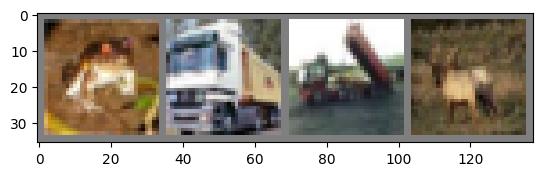

 frog truck truck  deer


In [ ]:
images, labels = zip(*[dataset[i] for i in range(4)])

images = torch.stack(images)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Train Test Split**

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1028,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1028,
                                         shuffle=False, num_workers=2)

print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 48000
Test set size: 12000



# **Base CNN Model**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(1024)
        self.conv6 = nn.Conv2d(1024, 2048, 3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(2048)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        x = torch.randn(2, 3, 32, 32)
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.pool(F.relu(self.batch_norm5(self.conv5(x))))
        x = torch.flatten(x, 1)
        input_size = x.shape[1]

        self.fc1 = nn.Linear(input_size, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.pool(F.relu(self.batch_norm5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

net = Net()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [ ]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        MaxPool2d-12            [-1, 512, 2, 2]               0
           Conv2d-13           [-1, 1024, 2, 2]       4,719,616
      BatchNorm2d-14           [-1, 102

# **Train and Evaluation**

Starting epoch 1 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.54it/s]


Epoch: 1, Learning Rate: 0.050000, Accuracy: 0.3724, Precision: 0.4781, Recall: 0.3710, Test Loss: 1.6620
Starting epoch 2 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.44it/s]


Epoch: 2, Learning Rate: 0.050000, Accuracy: 0.6028, Precision: 0.6161, Recall: 0.6007, Test Loss: 1.1038
Starting epoch 3 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.51it/s]


Epoch: 3, Learning Rate: 0.050000, Accuracy: 0.6019, Precision: 0.6698, Recall: 0.6004, Test Loss: 1.1189
Starting epoch 4 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.36it/s]


Epoch: 4, Learning Rate: 0.050000, Accuracy: 0.6422, Precision: 0.6790, Recall: 0.6407, Test Loss: 1.0582
Starting epoch 5 with learning rate 0.05


100%|██████████| 47/47 [00:14<00:00,  3.27it/s]


Epoch: 5, Learning Rate: 0.005000, Accuracy: 0.7462, Precision: 0.7536, Recall: 0.7454, Test Loss: 0.7293
Starting epoch 6 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:15<00:00,  3.02it/s]


Epoch: 6, Learning Rate: 0.005000, Accuracy: 0.7849, Precision: 0.7893, Recall: 0.7842, Test Loss: 0.6456
Starting epoch 7 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


Epoch: 7, Learning Rate: 0.005000, Accuracy: 0.7984, Precision: 0.8005, Recall: 0.7978, Test Loss: 0.6185
Starting epoch 8 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:14<00:00,  3.34it/s]


Epoch: 8, Learning Rate: 0.005000, Accuracy: 0.8028, Precision: 0.8040, Recall: 0.8018, Test Loss: 0.6329
Starting epoch 9 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:14<00:00,  3.27it/s]


Epoch: 9, Learning Rate: 0.005000, Accuracy: 0.7988, Precision: 0.7955, Recall: 0.7975, Test Loss: 0.6878
Starting epoch 10 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:14<00:00,  3.33it/s]


Epoch: 10, Learning Rate: 0.000500, Accuracy: 0.7989, Precision: 0.8026, Recall: 0.7980, Test Loss: 0.7307
Accuracy: 0.7989, Precision: 0.8026, Recall: 0.7980
Confusion Matrix:
 [[ 990   17   47   20   22    3    4    9   77   35]
 [   6 1086    2    6    1    1    6    1   22   69]
 [  59    1  830   75   76   34   66    6   11    5]
 [  15    6   44  803   49  112   90   23   18   14]
 [  17    2   52   68  927   12   41   28    9    4]
 [   7    0   36  296   47  742   27   46    3    3]
 [   5    4   32   62   30    7 1072    2    5    4]
 [  15    1   24   55   83   51    5  951    2   21]
 [  45   19    7   16    5    0    4    0 1109   29]
 [  25   42    3   11    1    2   12   10   24 1077]]


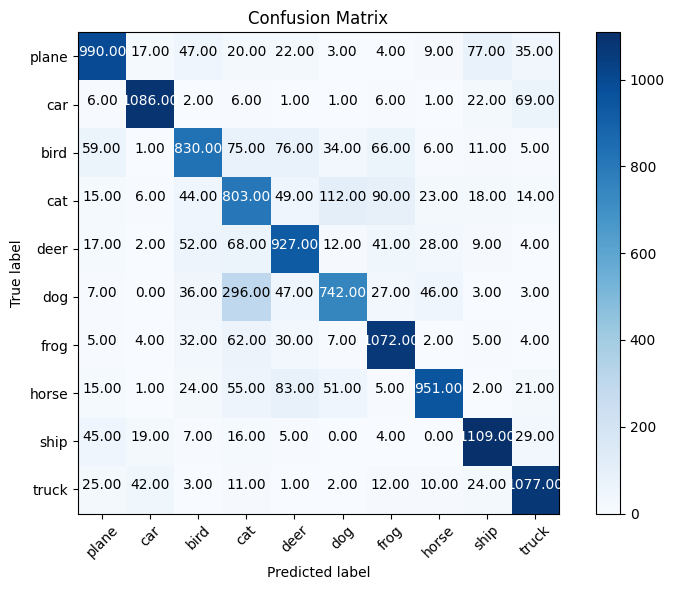

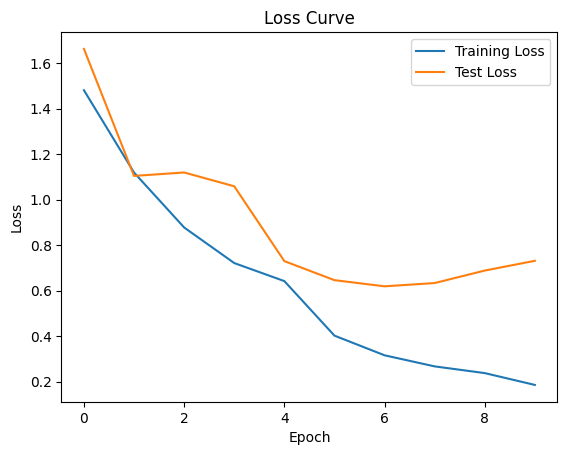

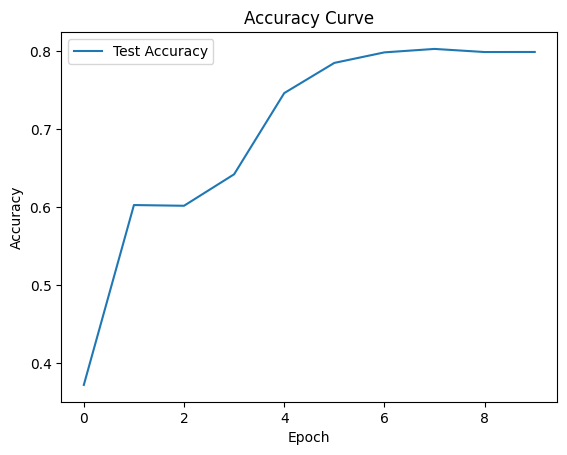

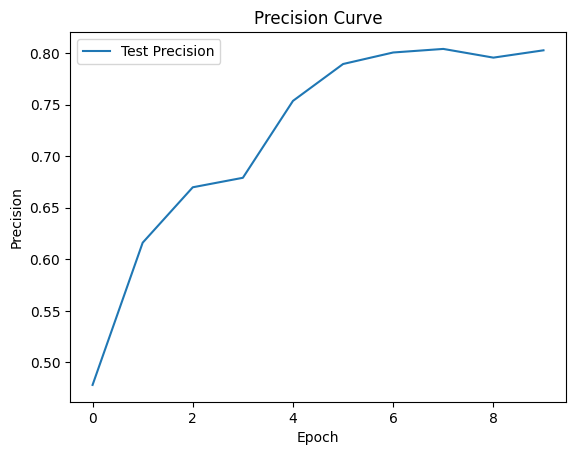

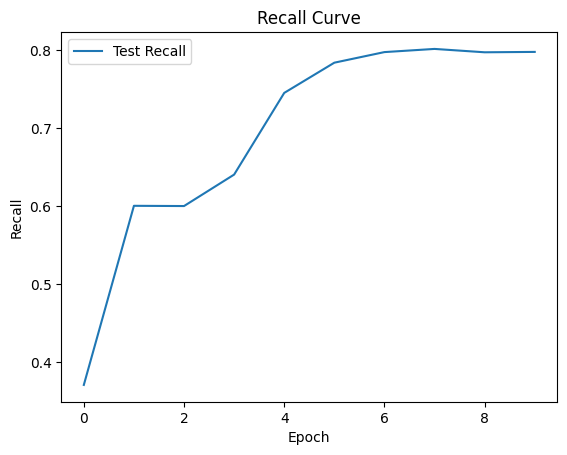

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
test_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
test_accuracies = []
test_precisions = []
test_recalls = []

for epoch in range(10):
    print(f'Starting epoch {epoch+1} with learning rate {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
#Train
    net.train()
    for i, data in enumerate(tqdm(trainloader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    scheduler.step()

#evaluate
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)

    print(f'Epoch: {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Test Loss: {test_loss / len(testloader):.4f}')

#confusion Matrix
net.eval()
test_loss = 0
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
print('Confusion Matrix:\n', conf_matrix)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = '.2f'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

#accuracy curve
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

#precision curve
plt.plot(test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Curve')
plt.show()

#recall curve
plt.plot(test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall Curve')
plt.show()

# **Data Augmentation**

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:

train_augmented_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_augmented_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

dataset_augmented = torch.utils.data.ConcatDataset([train_augmented_dataset, test_augmented_dataset])

train_size = int(0.8 * len(dataset_augmented))
test_size = len(dataset_augmented) - train_size

train_augmented_dataset, test_augmented_dataset = torch.utils.data.random_split(dataset_augmented, [train_size, test_size])

train_augmented_loader = torch.utils.data.DataLoader(train_augmented_dataset, batch_size=1024,
                                          shuffle=True, num_workers=2)

test_augmented_loader = torch.utils.data.DataLoader(test_augmented_dataset, batch_size=1024, shuffle=False)

print(f'Training set size: {len(train_augmented_dataset)}')
print(f'Test set size: {len(test_augmented_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Training set size: 48000
Test set size: 12000


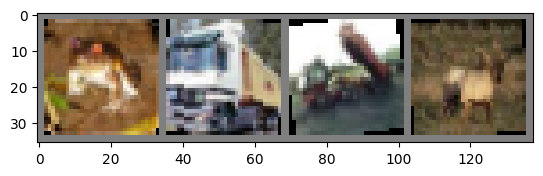

 frog truck truck  deer


In [ ]:
images, labels = zip(*[dataset_augmented[i] for i in range(4)])

images = torch.stack(images)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Starting epoch 1 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Epoch: 1, Learning Rate: 0.050000, Accuracy: 0.2976, Precision: 0.4160, Recall: 0.2966, Test Loss: 1.8720
Starting epoch 2 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.58it/s]


Epoch: 2, Learning Rate: 0.050000, Accuracy: 0.5825, Precision: 0.6293, Recall: 0.5814, Test Loss: 1.1276
Starting epoch 3 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.57it/s]


Epoch: 3, Learning Rate: 0.050000, Accuracy: 0.6271, Precision: 0.6606, Recall: 0.6243, Test Loss: 1.0550
Starting epoch 4 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.44it/s]


Epoch: 4, Learning Rate: 0.050000, Accuracy: 0.6825, Precision: 0.6935, Recall: 0.6805, Test Loss: 0.8826
Starting epoch 5 with learning rate 0.05


100%|██████████| 47/47 [00:13<00:00,  3.36it/s]


Epoch: 5, Learning Rate: 0.005000, Accuracy: 0.7063, Precision: 0.7233, Recall: 0.7040, Test Loss: 0.8755
Starting epoch 6 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:13<00:00,  3.49it/s]


Epoch: 6, Learning Rate: 0.005000, Accuracy: 0.7851, Precision: 0.7937, Recall: 0.7842, Test Loss: 0.6432
Starting epoch 7 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:13<00:00,  3.57it/s]


Epoch: 7, Learning Rate: 0.005000, Accuracy: 0.7887, Precision: 0.7917, Recall: 0.7875, Test Loss: 0.6587
Starting epoch 8 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:12<00:00,  3.66it/s]


Epoch: 8, Learning Rate: 0.005000, Accuracy: 0.7977, Precision: 0.7959, Recall: 0.7965, Test Loss: 0.6511
Starting epoch 9 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:13<00:00,  3.49it/s]


Epoch: 9, Learning Rate: 0.005000, Accuracy: 0.7876, Precision: 0.7897, Recall: 0.7863, Test Loss: 0.7221
Starting epoch 10 with learning rate 0.005000000000000001


100%|██████████| 47/47 [00:13<00:00,  3.46it/s]


Epoch: 10, Learning Rate: 0.000500, Accuracy: 0.7947, Precision: 0.7979, Recall: 0.7935, Test Loss: 0.7103
Accuracy: 0.7947, Precision: 0.7979, Recall: 0.7935
Confusion Matrix:
 [[1027   20   36   24    8    6    5   11   54   33]
 [   9 1112    2    5    1    4    1    1   11   54]
 [  71    2  871   64   48   42   34   20    8    3]
 [  28    4   55  766   24  183   67   22   12   13]
 [  30    1   96   74  805   38   41   65    3    7]
 [  10    3   31  241   34  818   18   49    1    2]
 [  10    3   63   98   22   12 1006    2    4    3]
 [  20    0   21   47   25   81    2  996    1   15]
 [  58   27   10   19    6    0    2    1 1080   31]
 [  23   66    3   17    2    6    3   13   19 1055]]


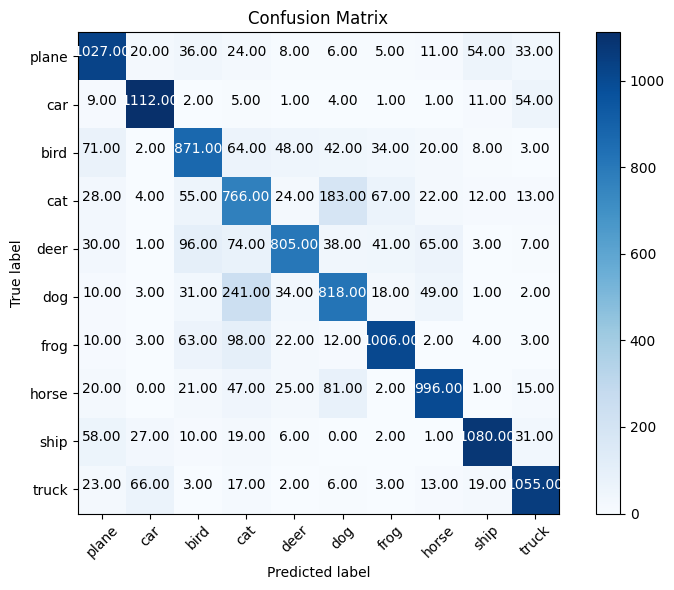

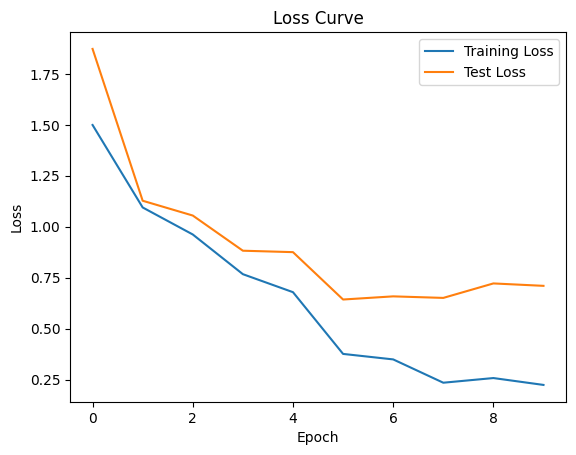

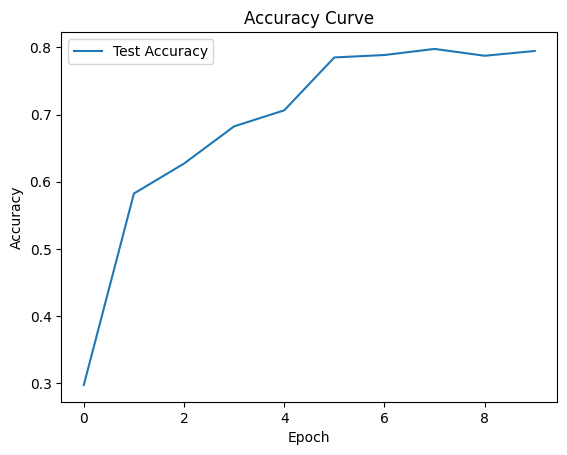

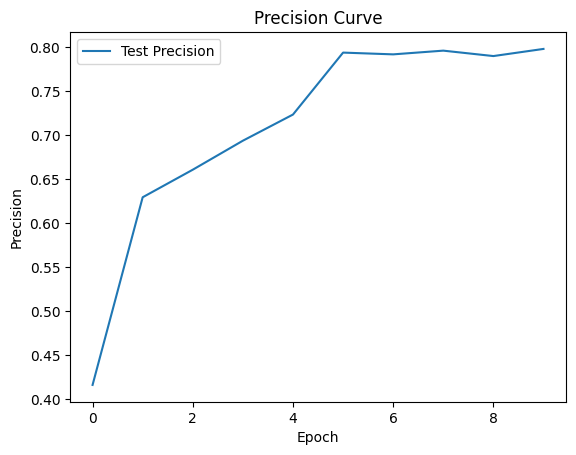

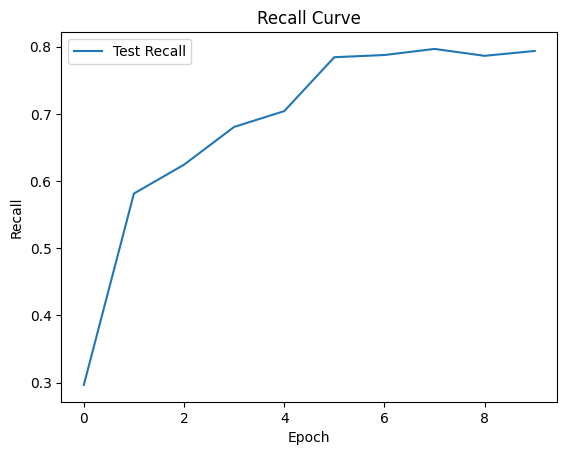

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-3)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
test_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
test_accuracies = []
test_precisions = []
test_recalls = []

for epoch in range(10):
    print(f'Starting epoch {epoch+1} with learning rate {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
    #train
    net.train()
    for i, data in enumerate(tqdm(trainloader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    scheduler.step()
#evaluate
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)

    print(f'Epoch: {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Test Loss: {test_loss / len(testloader):.4f}')

net.eval()
test_loss = 0
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
print('Confusion Matrix:\n', conf_matrix)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = '.2f'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

#accuracy curve
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

#precision curve
plt.plot(test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Curve')
plt.show()

#recall curve
plt.plot(test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall Curve')
plt.show()

ResNet50 model

In [16]:
import torchvision.models as models

In [22]:
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("mps")

In [23]:
pretrained_model = torchvision.models.resnet50(pretrained=True).to(device)

num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 10).to(device)

for param in pretrained_model.parameters():
    param.requires_grad = False

for param in pretrained_model.fc.parameters():
    param.requires_grad = True

for name, param in pretrained_model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

/Users/zeinebtekaya/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zeinebtekaya/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1 with learning rate 0.05


100%|██████████| 47/47 [01:44<00:00,  2.23s/it]


Epoch: 1, Learning Rate: 0.050000, Accuracy: 0.6204, Precision: 0.7265, Recall: 0.6223, Test Loss: 1.2131
Starting epoch 2 with learning rate 0.05


100%|██████████| 47/47 [02:15<00:00,  2.87s/it]


Epoch: 2, Learning Rate: 0.050000, Accuracy: 0.5938, Precision: 0.7548, Recall: 0.5957, Test Loss: 1.2818
Starting epoch 3 with learning rate 0.05


100%|██████████| 47/47 [01:52<00:00,  2.40s/it]


Epoch: 3, Learning Rate: 0.050000, Accuracy: 0.6892, Precision: 0.7431, Recall: 0.6889, Test Loss: 0.9640
Starting epoch 4 with learning rate 0.05


100%|██████████| 47/47 [02:01<00:00,  2.60s/it]


Epoch: 4, Learning Rate: 0.050000, Accuracy: 0.7355, Precision: 0.7525, Recall: 0.7342, Test Loss: 0.8019
Starting epoch 5 with learning rate 0.05


100%|██████████| 47/47 [01:51<00:00,  2.38s/it]


Epoch: 5, Learning Rate: 0.005000, Accuracy: 0.7538, Precision: 0.7660, Recall: 0.7529, Test Loss: 0.7602
Starting epoch 6 with learning rate 0.005000000000000001


100%|██████████| 47/47 [02:23<00:00,  3.05s/it]


Epoch: 6, Learning Rate: 0.005000, Accuracy: 0.8148, Precision: 0.8166, Recall: 0.8145, Test Loss: 0.5706
Starting epoch 7 with learning rate 0.005000000000000001


100%|██████████| 47/47 [01:50<00:00,  2.35s/it]


Epoch: 7, Learning Rate: 0.005000, Accuracy: 0.8175, Precision: 0.8190, Recall: 0.8175, Test Loss: 0.5556
Starting epoch 8 with learning rate 0.005000000000000001


100%|██████████| 47/47 [01:48<00:00,  2.31s/it]


Epoch: 8, Learning Rate: 0.005000, Accuracy: 0.8219, Precision: 0.8250, Recall: 0.8217, Test Loss: 0.5411
Starting epoch 9 with learning rate 0.005000000000000001


100%|██████████| 47/47 [02:21<00:00,  3.00s/it]


Epoch: 9, Learning Rate: 0.005000, Accuracy: 0.8160, Precision: 0.8172, Recall: 0.8156, Test Loss: 0.5556
Starting epoch 10 with learning rate 0.005000000000000001


100%|██████████| 47/47 [01:49<00:00,  2.32s/it]


Epoch: 10, Learning Rate: 0.000500, Accuracy: 0.8202, Precision: 0.8207, Recall: 0.8203, Test Loss: 0.5512
Accuracy: 0.8183, Precision: 0.8185, Recall: 0.8186
Confusion Matrix:
 [[ 979   12   44   23    9    8   10   11   24   26]
 [   5 1073    3    2    4    2   11    6    6   51]
 [  47    6 1025   21   50   29   48   16    4    4]
 [  11    9   56  768   71  187   69   28    2   13]
 [  16    2   57   36  966   36   23   59    3    7]
 [   5    4   45  127   52  858   17   42    3    9]
 [   9    2   28   54   30   18 1096    3    3    5]
 [   6    3   27   30   58   44    4 1012    2    5]
 [  89   54    6   15    4    0    2    1 1024   40]
 [  24   92    4   12    4    5    4    9   13 1019]]


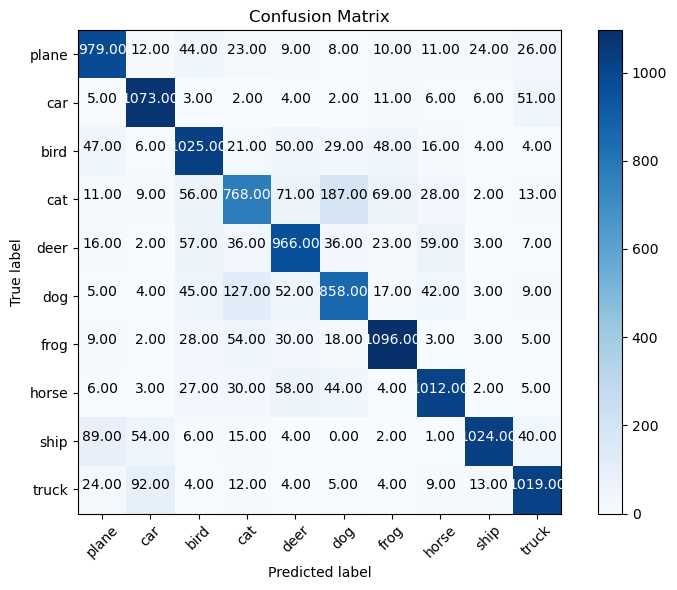

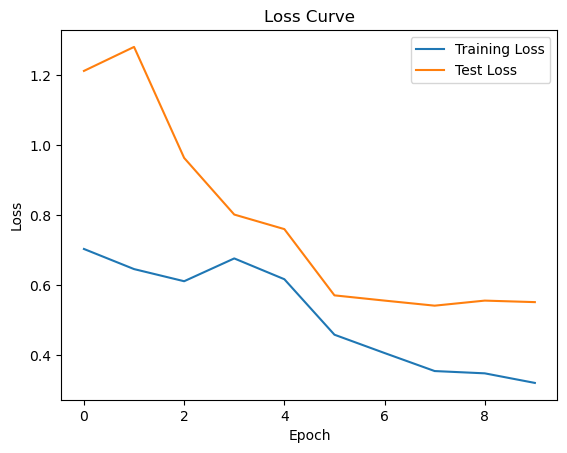

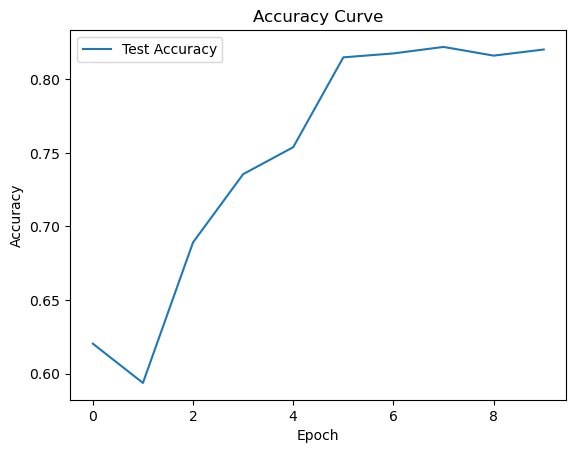

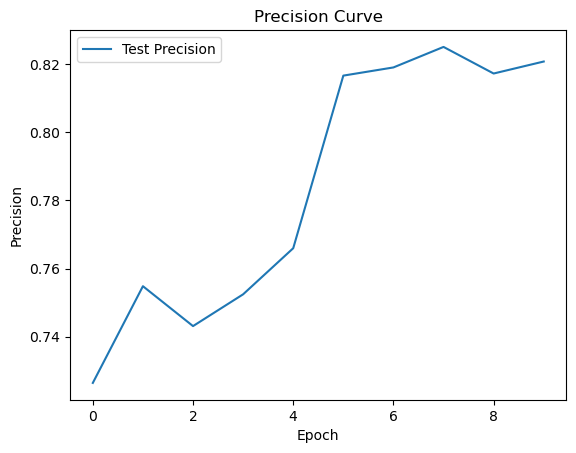

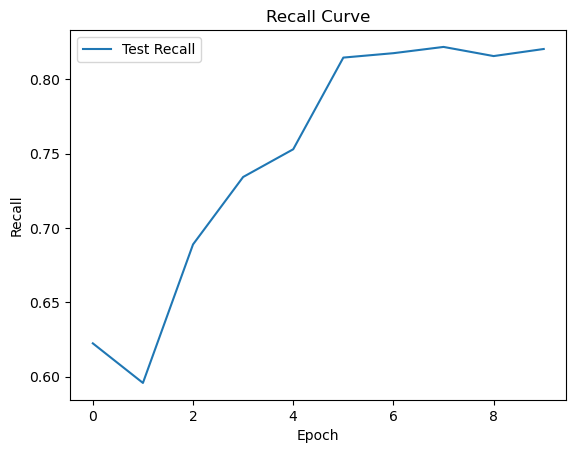

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=0.05, momentum=0.9, weight_decay=2e-2)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
test_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
test_accuracies = []
test_precisions = []
test_recalls = []

for epoch in range(10):
    print(f'Starting epoch {epoch+1} with learning rate {optimizer.param_groups[0]["lr"]}')
    running_loss = 0.0
    pretrained_model.train()
    for i, data in enumerate(tqdm(train_augmented_loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    scheduler.step()

    pretrained_model.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data in test_augmented_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(true_labels, predictions, average='macro')
    recall = recall_score(true_labels, predictions, average='macro')
    test_losses.append(test_loss / len(test_augmented_loader))
    test_accuracies.append(accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)

    print(f'Epoch: {epoch+1}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Test Loss: {test_loss / len(test_augmented_loader):.4f}')

pretrained_model.eval()
test_loss = 0
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for data in test_augmented_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
print('Confusion Matrix:\n', conf_matrix)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = '.2f'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

#accuracy curve
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

#precision curve
plt.plot(test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Curve')
plt.show()

#recall curve
plt.plot(test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall Curve')
plt.show()